Author documentation: 
- Student data, timesheets
- Required libraries and installs (e.g. „pip“ commands)
- Description of data and ground truth + split for training, testing, validation. Please do not include the videos themselves.
- Description of feature extraction methods (if applicable)
- Classification: Process and results of training and testing
- Results: Results of validation, indicators + the mandatory ROC curves of classifier performance
- Discussion of results

# Similarity Modeling 1/2: Recognizing Swedish Chef with Deep Learning  

#### Student
Matthias Hofmaier (11944050)
#### Timesheet

2022/11/23 | 16:30 - 18:00 | Setup Jupyter Environment and Project          

2022/11/23 | 18:00 - 19:30 | Exploration and Preparation of Ground Truth

2022/11/23 | 19:30 - 20:30 | Research for Potential Implementation Strategies

2022/11/24 | 09:00 - 11:30 | Video to audio conversion and spectrogram creation

#### Required libraries and installs

In [97]:
!cat requirements-dl-audio.txt
#!pip install -r requirements-dl-audio.txt

python==3.9
pandas
numpy
matplotlib
opencv-python
ffmpeg-python


**NOTE:** ffmpeg has to be installed on your device!
This can be done with one of the following commands:

In [120]:
#!brew install ffmpeg # MacOS (tested)
#!sudo apt install ffmpeg # Ubuntu (not tested)

For windows check: https://phoenixnap.com/kb/ffmpeg-windows

## Imports

In [129]:
import os

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import librosa
import librosa.display

## Constants

In [118]:
DATA_PATH = "../data/"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")

# 1. Data Preparation

## 1.1 Load ground truth data
The columns in the CSV files indicate at which frames Kermit, Waldorf & Statler, Pigs and/or the Danish chef are visually present (no prefix) or can be heared ("Audio_*").

In [100]:
gts = []
for fname in os.listdir(GROUND_TRUTH_PATH):
    if fname.startswith("GroundTruth"):
        df = pd.read_csv(os.path.join(GROUND_TRUTH_PATH, fname), sep=";")
        gts.append(df)
gts[0].head()

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy
0,343,0,0,0,0,0,0,0,0,0
1,343,1,0,0,0,0,0,0,0,0
2,343,2,0,0,0,0,0,0,0,0
3,343,3,0,0,0,0,0,0,0,0
4,343,4,0,0,0,0,0,0,0,0


The column that is of our interest is 'Audio_Cook'.

## 1.2 Load video data

In [101]:
# def load_video(path):
videos = []
for fname in os.listdir(VIDEO_PATH):
    if fname.startswith("Muppets"):
        vidcap = cv2.VideoCapture(os.path.join(VIDEO_PATH, fname))
        fps = vidcap.get(cv2.CAP_PROP_FPS)
        videos.append(vidcap)
        print(f"Loaded video {fname} with {fps} frames per second")

Loaded video Muppets-02-01-01.avi with 25.0 frames per second
Loaded video Muppets-03-04-03.avi with 25.0 frames per second
Loaded video Muppets-02-04-04.avi with 25.0 frames per second


All of the videos have 25 frames per second. This comes in handy for the exploration of csv data.

In [102]:
FPS = 25

## 1.3 Show some descriptions of the data

Video: 343
Number of frames: 38498
Number of frames with Audio_Cook: 284
Length: 1539.92 seconds


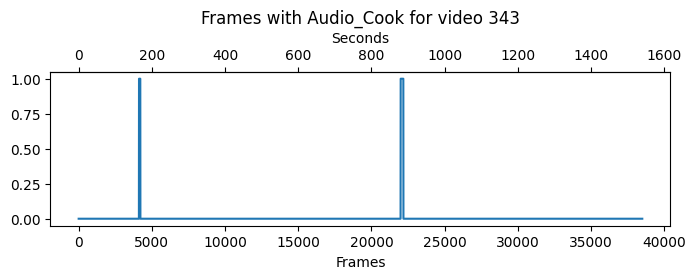

Video: 244
Number of frames: 38706
Number of frames with Audio_Cook: 0
Length: 1548.24 seconds


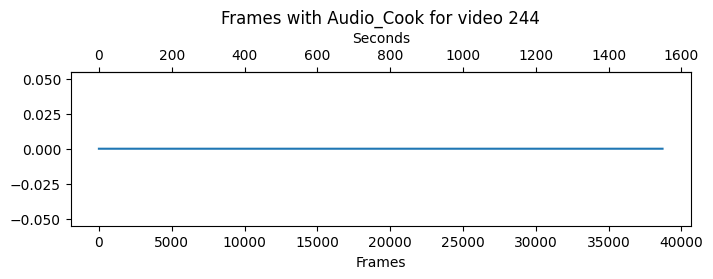

Video: 211
Number of frames: 38681
Number of frames with Audio_Cook: 1157
Length: 1547.24 seconds


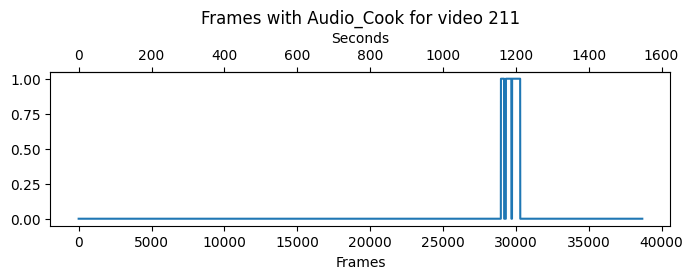

In [103]:
def show_gt_description(df, column="Audio_Cook", fps=25):
    print(f"Video: {df.loc[0, 'Video']}")
    print(f"Number of frames: {df['Frame_number'].count()}")
    print(
        f"Number of frames with {column}: {df.loc[df[column] == 1, 'Frame_number'].count()}"
    )
    print(f"Length: {len(df['Frame_number']) / fps} seconds")

    # plotting with frames and seconds as x-axis
    fig = plt.figure(figsize=(8, 2))
    ax1 = fig.add_subplot(111)
    ax1.set_title(f"Frames with {column} for video {df.loc[0, 'Video']}")
    ax1.set_xlabel("Frames")
    frame_indicator = np.zeros(len(df["Frame_number"]))
    frame_indicator[df[df[column] == 1].index] = 1
    ax1.plot(df[column].index, frame_indicator)

    def frames_to_sec(x):
        return x / fps

    def sec_to_frames(x):
        return x * fps

    ax2 = ax1.secondary_xaxis("top", functions=(frames_to_sec, sec_to_frames))
    ax2.set_xlabel("Seconds")
    plt.show()


show_gt_description(gts[0])
show_gt_description(gts[1])
show_gt_description(gts[2])

We can see that the swedish chef occurs only in the audio of video 343 and 211. In the next step, we will combine our ground truth dataframes into one, filter for the Audio_Cook column and add a column seconds to the data frame. 

## 1.4 Combine data frames, filter for Audio_Cook and add seconds

In [104]:
df_gt = pd.concat(gts)
df_gt["Seconds"] = df_gt["Frame_number"] / FPS
df_gt = df_gt[["Video", "Frame_number", "Seconds", "Audio_Cook"]]
df_gt.head()

,Video,Frame_number,Seconds,Audio_Cook
0,343,0,0.00,0
1,343,1,0.04,0
2,343,2,0.08,0
3,343,3,0.12,0
4,343,4,0.16,0


In the next step, we will convert the video files to wav format

## 1.5 Convert videos to wav

In [122]:
map_code_to_file = {
    211: "02-01-01",
    244: "02-04-04",
    343: "03-04-03"
}

AUDIO_PATH = '../data/audio/'
os.makedirs(AUDIO_PATH, exist_ok=True)


for code in df_gt['Video'].unique():
    fname_in = f"Muppets-{map_code_to_file[code]}.avi"
    fname_out = f"Muppets-{map_code_to_file[code]}.wav"
    command2wav = f"ffmpeg -i {os.path.join(VIDEO_PATH, fname_in)} {os.path.join(AUDIO_PATH, fname_out)}"
    os.system(command2wav)
    
    gt_df.loc[gt_df['Video'] == code, 'fname_audio'] = fname_out # save audio filename to data frame
    
    #audio_in = AudioSegment.from_file(os.path.join(VIDEO_PATH, fname_in), format="avi")                                                

    
    
    print(f"Converted {fname_in} to {fname_out}")
    
    
    
#def extract_audio(self, filename):
#        try:
#            out, err = (
#                ffmpeg
#                .input(filename)
#                .output('-', format='f32le', acodec='pcm_f32le', ac=1, ar='44100')
#                .run(cmd=self.cmd, capture_stdout=True, capture_stderr=True)
#            )
#        except Error as err:
#            print(err.stderr)
#            raise

Converted Muppets-03-04-03.avi to Muppets-03-04-03.wav
Converted Muppets-02-04-04.avi to Muppets-02-04-04.wav
Converted Muppets-02-01-01.avi to Muppets-02-01-01.wav


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.102)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolb

## 1.6 Create Mel Spectrograms
We will now use the converted audio data to create Mel Spectrograms

TODO: Find parameters that spectrogram frames match video frames

In [139]:
16000/25

640.0

/Users/mhf/opt/anaconda3/envs/sm-dl-audio/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


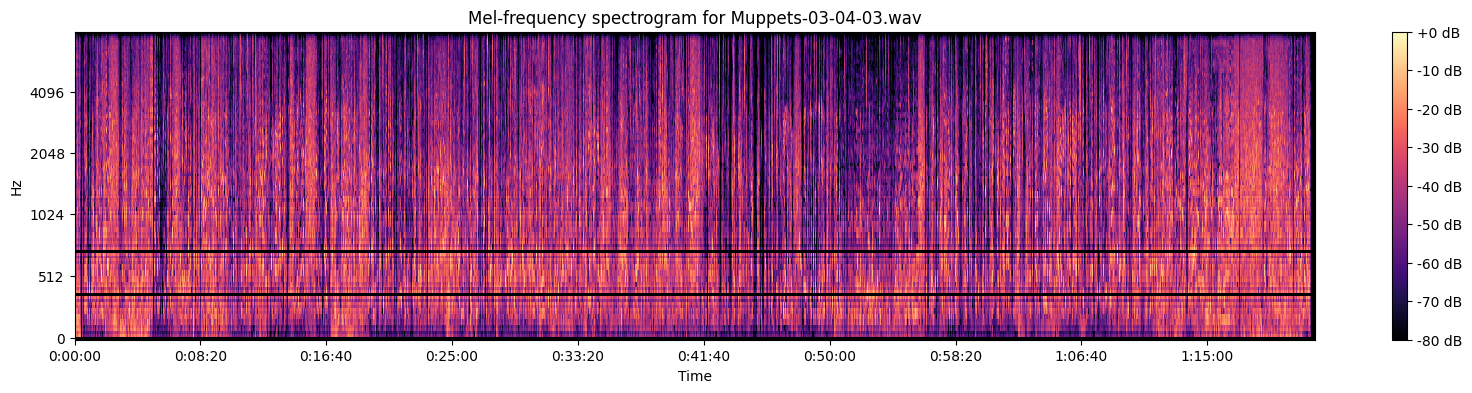

In [161]:
SR = 16000 # we will use a sample rate of 16kHz
N_FFT = 320
HOP_LENGTH = 160
N_MELS = 128

spectrograms = []

for fname_audio in gt_df['fname_audio'].unique():
    y, sr = librosa.load(os.path.join(AUDIO_PATH, fname_audio), sr=SR)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS) 
    spectrograms.append(S)
    
    fig, ax = plt.subplots(figsize=(20, 4))
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=f'Mel-frequency spectrogram for {fname_audio}')
    break


In [162]:
spectrograms[0].shape

(128, 153946)

In [163]:
librosa.frames_to_time(np.arange(spectrograms[0].shape[1]), sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH)[:10]

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [150]:
1.53946e+03

1539.46

In [124]:
gt_df

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy,fname_audio
0,343,0,0,0,0,0,0,0,0,0,Muppets-03-04-03.wav
1,343,1,0,0,0,0,0,0,0,0,Muppets-03-04-03.wav
2,343,2,0,0,0,0,0,0,0,0,Muppets-03-04-03.wav
3,343,3,0,0,0,0,0,0,0,0,Muppets-03-04-03.wav
4,343,4,0,0,0,0,0,0,0,0,Muppets-03-04-03.wav
...,...,...,...,...,...,...,...,...,...,...,...
38676,211,38676,0,0,0,0,0,0,0,0,Muppets-02-01-01.wav
38677,211,38677,0,0,0,0,0,0,0,0,Muppets-02-01-01.wav
38678,211,38678,0,0,0,0,0,0,0,0,Muppets-02-01-01.wav
38679,211,38679,0,0,0,0,0,0,0,0,Muppets-02-01-01.wav


https://github.com/DTaoo/VGGish